**目标：根据历史数据，预测当天股票最高价**

**1. 改为用 30 天预测 7 天的股价**  
**2. 测试只有前 30 天的数据，预测后面所有的数据**

## 模块导入

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

## 数据读取

### 原始数据获取

In [2]:
import tushare as ts

cons = ts.get_apis()
df = ts.bar('000300', conn=cons, asset='INDEX', start_date='2002-01-01', end_date='')

# 注意历史数据靠前
df = df.sort_index(ascending=True)
df.to_csv('sh.csv')

# 可以看出，周末不进行交易
df.head(20)

,code,open,close,high,low,vol,amount,p_change
datetime,,,,,,,,
2005-01-04,000300,994.76,982.79,994.76,980.65,74128.0,4.431976e+09,NaN
2005-01-05,000300,981.57,992.56,997.32,979.87,71191.0,4.529207e+09,0.99
2005-01-06,000300,993.33,983.17,993.78,980.33,62880.0,3.921015e+09,-0.95
2005-01-07,000300,983.04,983.95,995.71,979.81,72986.0,4.737468e+09,0.08
2005-01-10,000300,983.76,993.87,993.95,979.78,57916.0,3.762931e+09,1.01
2005-01-11,000300,994.18,997.13,999.55,991.09,58490.0,3.704076e+09,0.33
2005-01-12,000300,996.65,996.74,996.97,989.25,50145.0,3.093298e+09,-0.04
2005-01-13,000300,996.07,996.87,999.47,992.69,60440.0,3.842172e+09,0.01
2005-01-14,000300,996.61,988.30,1006.46,987.23,72978.0,4.162920e+09,-0.86


### 数据预处理

In [3]:
df = pd.read_csv('sh.csv', index_col=0)
df.index = list(map(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'), df.index))
df.head()

,code,open,close,high,low,vol,amount,p_change
2005-01-04,300,994.76,982.79,994.76,980.65,74128.0,4.431976e+09,NaN
2005-01-05,300,981.57,992.56,997.32,979.87,71191.0,4.529207e+09,0.99
2005-01-06,300,993.33,983.17,993.78,980.33,62880.0,3.921015e+09,-0.95
2005-01-07,300,983.04,983.95,995.71,979.81,72986.0,4.737468e+09,0.08
2005-01-10,300,983.76,993.87,993.95,979.78,57916.0,3.762931e+09,1.01


In [4]:
def getData(df, column, train_end=-300, days_before=30, days_pred=7, return_all=True, generate_index=False):
    series = df[column].copy()
    
    # 创建训练集
    data = pd.DataFrame()
    
    # 准备天数
    for i in range(days_before):
        # 最后的 -days_before - days_pred 天只是用于预测值，预留出来
        data['b%d' % i] = series.tolist()[i: -days_before - days_pred + i]
    
    # 预测天数
    for i in range(days_pred):
        data['y%d' % i] = series.tolist()[days_before + i: - days_pred + i]
        
    # 是否生成 index
    if generate_index:
        data.index = series.index[days_before:]
        
    train_data, val_data, test_data = data[:train_end-300], data[train_end-300:train_end], data[train_end:]
                
    if return_all:
        return train_data, val_data, test_data, series, df.index.tolist()
    
    return train_data, val_data, test_data

## 创建 LSTM 层

In [5]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=1,   # 输入尺寸为 1，表示一天的数据
            hidden_size=128,
            num_layers=1, 
            batch_first=True)
        
        self.out = nn.Sequential(
            nn.Linear(128, 1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)   # None 表示 hidden state 会用全 0 的 state
        out = self.out(r_out[:, -7:, :])          # 取最后一天作为输出
        
        return out

In [6]:
class TrainSet(Dataset):
    def __init__(self, data):
        self.data, self.label = data[:, :-7].float(), data[:, -7:].float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

## 超参数

In [7]:
LR = 0.0001
EPOCH = 1000
TRAIN_END=-300
DAYS_BEFORE=30
DAYS_PRED=7

## 模型训练

### 获取数据
- 训练模型仍然使用 minibatch 的思路
- 注意，模型必须要先把数据标准化，不然损失会很难降低下来。

/home/leon/TankZhou/env/python3.7-pytorch1.0.1/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


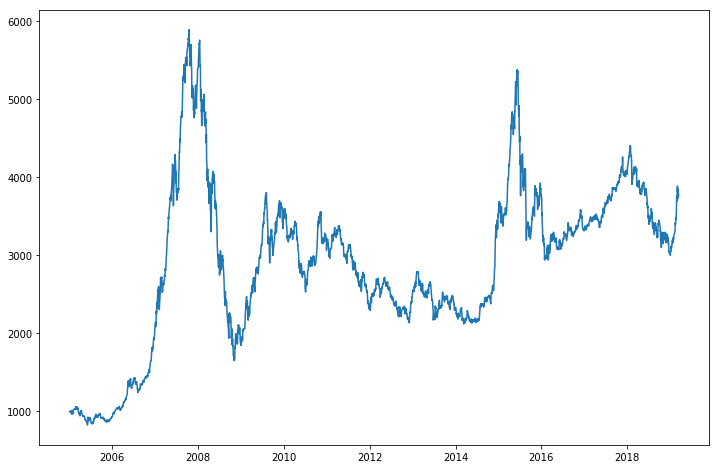

In [8]:
# 数据集建立
train_data, val_data, test_data, all_series, df_index = getData(df, 'high', days_before=DAYS_BEFORE, days_pred=DAYS_PRED, train_end=TRAIN_END)

# 获取所有原始数据
all_series_test1 = np.array(all_series.copy().tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series_test1, label='real-data')

# 归一化，便与训练
train_data_numpy = np.array(train_data)
train_mean = np.mean(train_data_numpy)
train_std  = np.std(train_data_numpy)
train_data_numpy = (train_data_numpy - train_mean) / train_std
train_data_tensor = torch.Tensor(train_data_numpy)

val_data_numpy = np.array(val_data)
val_data_numpy = (val_data_numpy - train_mean) / train_std
val_data_tensor = torch.Tensor(val_data_numpy)

test_data_numpy = np.array(train_data)
test_data_numpy = (test_data_numpy - train_mean) / train_std
test_data_tensor = torch.Tensor(test_data_numpy)

# 创建 dataloader
train_set = TrainSet(train_data_tensor)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

val_set = TrainSet(val_data_tensor)
val_loader = DataLoader(val_set, batch_size=256, shuffle=True)

In [9]:
# for tx, ty in train_loader:
#     print(tx.shape)
#     print(ty.shape)

## 模型训练部分

这个部分如果是不想要训练的话（比如已经训练好了模型），替换为 rnn = torch.load('rnn.pkl') （记得把原来的注释掉）

In [10]:
# rnn = LSTM()

# if torch.cuda.is_available():
#     rnn = rnn.cuda()

# optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)  # optimize all cnn parameters
# loss_func = nn.MSELoss()

# best_loss = 1000


# if not os.path.exists('weights'):
#     os.mkdir('weights')    

# for step in range(EPOCH):
#     for tx, ty in train_loader:
#         if torch.cuda.is_available():
#             tx = tx.cuda()
#             ty = ty.cuda() 
        
#         output = rnn(torch.unsqueeze(tx, dim=2))             
#         loss = loss_func(torch.squeeze(output), ty)        
#         optimizer.zero_grad()  # clear gradients for this training step
#         loss.backward()  # back propagation, compute gradients
#         optimizer.step()
        
#         print('epoch : %d  ' % step, 'train_loss : %.4f' % loss.cpu().item())
        
#     with torch.no_grad():
#         for tx, ty in val_loader:
#             if torch.cuda.is_available():
#                 tx = tx.cuda()
#                 ty = ty.cuda() 
        
#             output = rnn(torch.unsqueeze(tx, dim=2))             
#             loss = loss_func(torch.squeeze(output), ty)
        
#             print('epoch : %d  ' % step, 'val_loss : %.4f' % loss.cpu().item())
        
#         if loss.cpu().item() < best_loss:
#             best_loss = loss.cpu().item()
#             torch.save(rnn, 'weights/rnn.pkl'.format(loss.cpu().item()))
#             print('new model saved at epoch {} with val_loss {}'.format(step, best_loss))

## 画图

In [11]:
rnn = LSTM()

rnn = torch.load('weights/rnn.pkl')

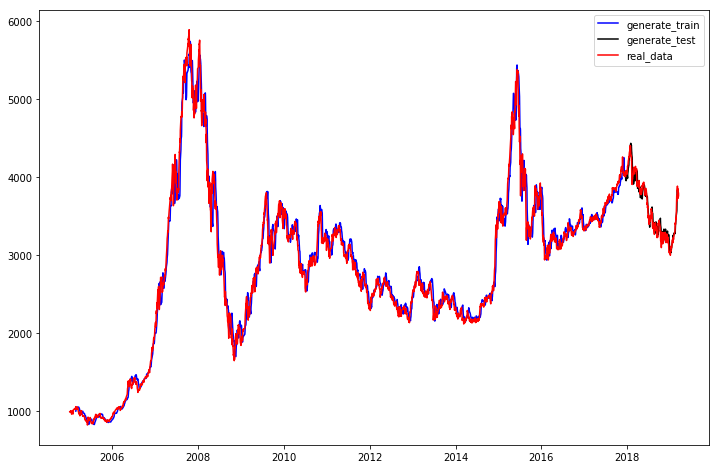

In [12]:
generate_data_train = []
generate_data_test = []

# 测试数据开始的索引
test_start = len(all_series_test1) + TRAIN_END

# 对所有的数据进行相同的归一化
all_series_test1 = (all_series_test1 - train_mean) / train_std
all_series_test1 = torch.Tensor(all_series_test1)

# len(all_series_test1)  # 3448

for i in range(DAYS_BEFORE, len(all_series_test1) - DAYS_PRED, DAYS_PRED):
    x = all_series_test1[i - DAYS_BEFORE:i]
    # 将 x 填充到 (bs, ts, is) 中的 timesteps
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=2)
    
    if torch.cuda.is_available():
        x = x.cuda()

    y = torch.squeeze(rnn(x))
    
    if i < test_start:
        generate_data_train.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
    else:
        generate_data_test.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
        
generate_data_train = np.concatenate(generate_data_train, axis=0)
generate_data_test  = np.concatenate(generate_data_test, axis=0)

# print(len(generate_data_train))   # 3122
# print(len(generate_data_test))    # 294

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: len(generate_data_train) + DAYS_BEFORE], generate_data_train, 'b', label='generate_train')
plt.plot(df_index[TRAIN_END:len(generate_data_test) + TRAIN_END], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series_test1.clone().numpy() * train_std + train_mean, 'r', label='real_data')
plt.legend()
plt.show()

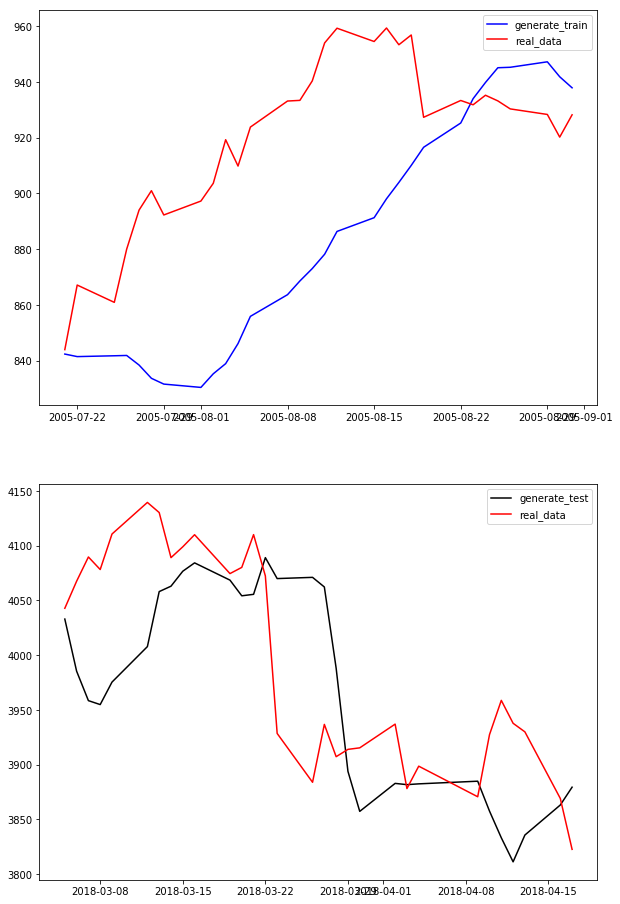

In [13]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series_test1.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END + 50: TRAIN_END + 80], generate_data_test[50:80], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END + 50: TRAIN_END + 80], (all_series_test1.clone().numpy()* train_std + train_mean)[TRAIN_END + 50: TRAIN_END + 80], 'r', label='real_data')
plt.legend()

plt.show()

3448
3448
3446


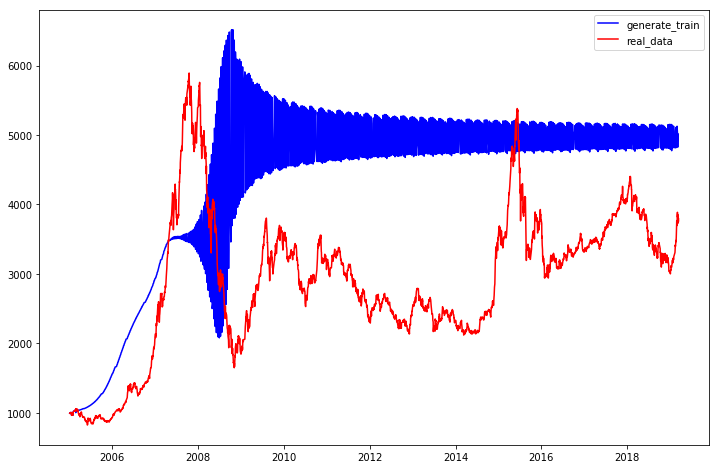

In [14]:
generate_data_train = []
generate_data_test = []

all_series_test2 = np.array(all_series.copy().tolist())

# 对所有的数据进行相同的归一化
all_series_test2 = (all_series_test2 - train_mean) / train_std
all_series_test2 = torch.Tensor(all_series_test2)

iter_series = all_series_test2[:DAYS_BEFORE]

index = DAYS_BEFORE

while index < len(all_series_test2) - DAYS_PRED:
    x = torch.unsqueeze(torch.unsqueeze(iter_series[-DAYS_BEFORE:], dim=0), dim=2)
    
    if torch.cuda.is_available():
        x = x.cuda()

    y = torch.squeeze(rnn(x))
    
    iter_series = torch.cat((iter_series.cpu(), y.cpu()))
    
    index += DAYS_PRED

iter_series = iter_series.detach().cpu().clone().numpy() * train_std + train_mean

print(len(all_series_test2))
print(len(df_index))
print(len(iter_series))

plt.figure(figsize=(12,8))
plt.plot(df_index[ : len(iter_series)], iter_series, 'b', label='generate_train')
plt.plot(df_index, all_series_test2.clone().numpy() * train_std + train_mean, 'r', label='real_data')
plt.legend()
plt.show()

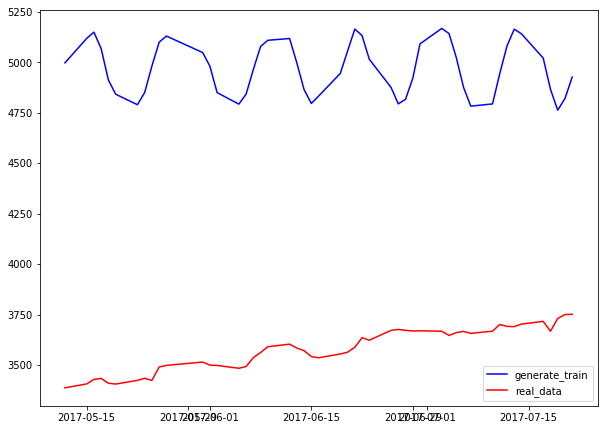

In [15]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
plt.plot(df_index[ 3000 : 3049], iter_series[3000:3049], 'b', label='generate_train')
plt.plot(df_index[ 3000 : 3049], all_series_test2.clone().numpy()[3000 : 3049] * train_std + train_mean, 'r', label='real_data')
plt.legend()

plt.show()